# Código para o método PROMETHEE-Score

iniciarei importando algumas bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PROMETHEE import PROMETHEE_2

In [3]:
dados = pd.read_excel("dados.xlsx", index_col=0)
dados = dados.dropna(axis=0)
dados.loc["Hong Kong"]

Property Rights           93.3
Judical Effectiveness     75.3
Government Integrity      83.8
Tax Burden                93.1
Gov't Spending            90.3
Fiscal Health            100.0
Business Freedom          96.4
Labor Freedom             89.2
Monetary Freedom          86.4
Trade Freedom             95.0
Investment Freedom        90.0
Financial Freedom         90.0
Name: Hong Kong, dtype: float64

In [4]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [6]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

net_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1]

In [7]:
pd.DataFrame(net_flows, index=dados.index).loc["Hong Kong"]

0    0.849675
Name: Hong Kong, dtype: float64

### SMAA

- Vamos agora rodar o PROMETHEE no mesmo conjunto de dados, porém, usaremos variáveis aleatórias.

In [8]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [9]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= dados.index)
Sigma_Mu_df.columns


Index(['Sigma', 'Mu'], dtype='object')

c:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


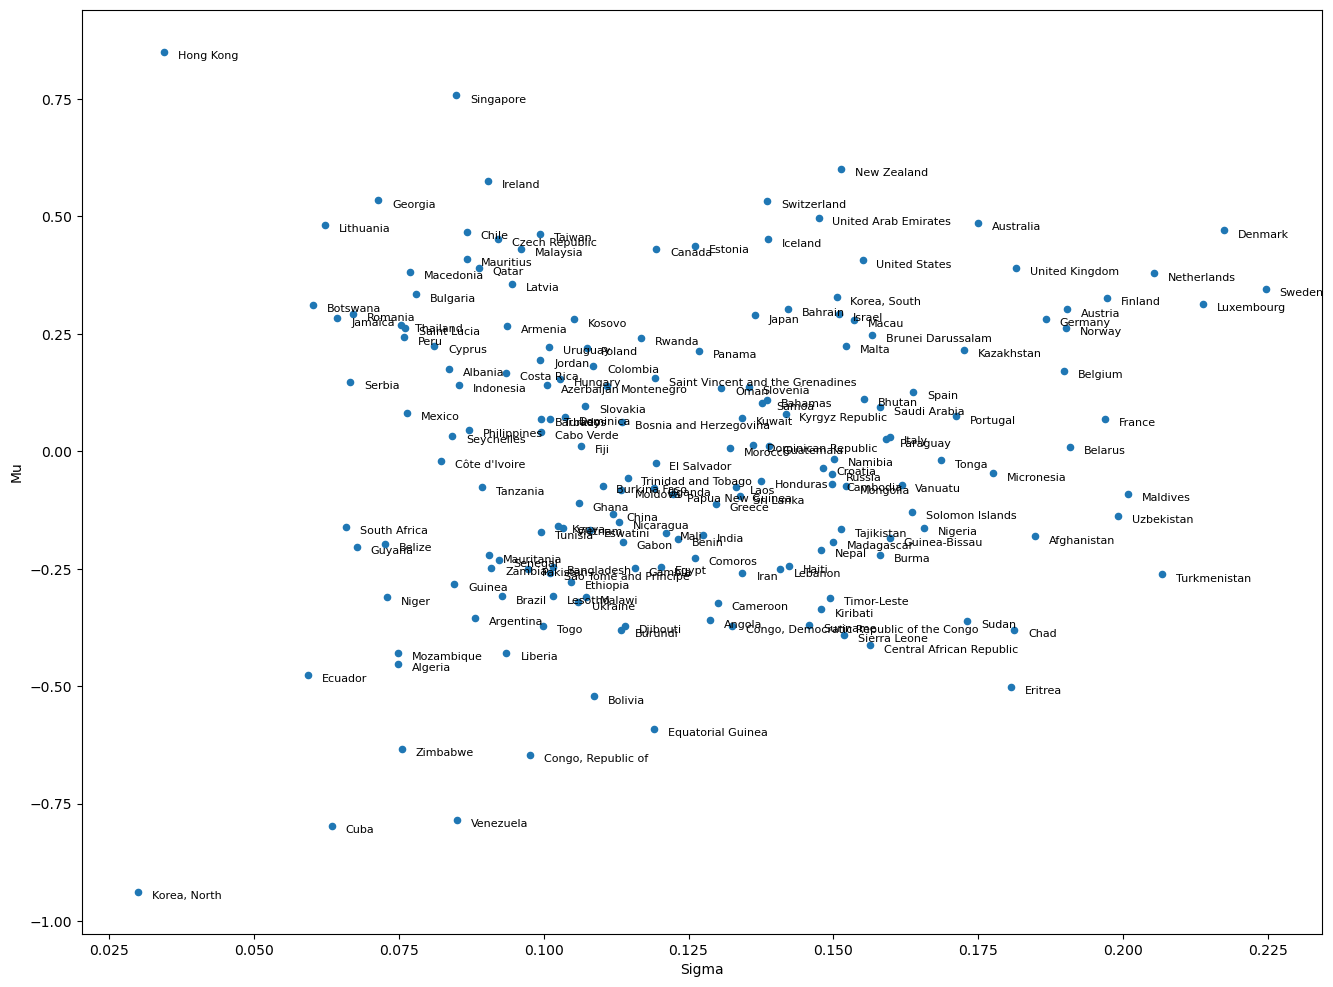

In [10]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [11]:
# Possívei ideia de usar KMeans antes da otimização
"""
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)
kmeans.labels_

Sigma_Mu_df.assign(Category = kmeans.labels_)

Sigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)
Sigma_Mu_df_clusters
"""

'\nfrom sklearn.cluster import KMeans\nkmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)\nkmeans.labels_\n\nSigma_Mu_df.assign(Category = kmeans.labels_)\n\nSigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)\nSigma_Mu_df_clusters\n'

### PKFs 

In the cell below, I'll obtain the PKFs for the Sigma-Mu plot 

In [14]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1



PKF_1: ['Hong Kong', 'Korea, North ']
PKF_2: ['Botswana', 'Ecuador', 'Georgia', 'Lithuania', 'Singapore']
PKF_3: ['Chile', 'Cuba', 'Ireland', 'Jamaica', 'Macedonia', 'New Zealand', 'Romania']
PKF_4: ['Bulgaria', 'Czech Republic', 'Mauritius', 'Serbia', 'South Africa', 'Switzerland', 'Taiwan ', 'Thailand']
PKF_5: ['Belize', 'Canada', 'Estonia', 'Guyana', 'Iceland', 'Malaysia', 'Peru', 'Qatar', 'Saint Lucia', 'United Arab Emirates']
PKF_6: ['Armenia', 'Australia', 'Cyprus', 'Latvia', 'Mexico', 'Niger', 'United States']
PKF_7: ['Albania', 'Bahrain', "Côte d'Ivoire", 'Denmark', 'Japan', 'Jordan', 'Korea, South', 'Kosovo', 'Mozambique', 'United Kingdom', 'Uruguay']
PKF_8: ['Algeria', 'Austria', 'Costa Rica', 'Finland', 'Indonesia', 'Israel', 'Netherlands', 'Poland', 'Rwanda', 'Seychelles']
PKF_9: ['Azerbaijan', 'Barbados', 'Colombia', 'Germany', 'Guinea', 'Hungary', 'Luxembourg', 'Macau', 'Malta', 'Panama', 'Philippines', 'Sweden', 'Zimbabwe']
PKF_10: ['Argentina', 'Brunei Darussalam', 'Cab

### Otimização

O Score das alternativas é obtido através de um modelo de otimização linear.

In [28]:
from PROMETHEE import optimize_PROM2_original, optimize_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')


alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 

In [29]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Korea, North "]

Global Efficiency     1.429025
Position             64.000000
Name: Korea, North , dtype: float64

In [33]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Korea, North "]

Global Efficiency    -16.056639
Position             180.000000
Name: Korea, North , dtype: float64